<a href="https://colab.research.google.com/github/tashinam/piano_generation/blob/main/drawing_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!git clone https://github.com/tashinam/piano_generation.git

Cloning into 'piano_generation'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 115 (delta 2), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (115/115), 3.98 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
%%capture
!pip install -qU pyfluidsynth pretty_midi mido pytorch-lightning wandb
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev

In [3]:
!pip install pyfluidsynth

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%cd /content/piano_generation/
!git stash
!git pull
%cd /content/

/content/piano_generation
No local changes to save
Already up to date.
/content


In [6]:
import ctypes.util
import IPython.display
import mido
import os
import pretty_midi
import sys
import time
import torch
import wandb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

from base64 import b64decode
from google.colab.output import eval_js
from IPython.display import HTML, Image
from matplotlib.animation import FuncAnimation
from piano_generation.models import *
from piano_generation.util import *
from pytorch_lightning.callbacks import ModelCheckpoint
from scipy.fftpack import dct, idct
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

# reload fluidsynth samples
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

# connect to weights and biases
# wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Model

### Set Parameters

In [20]:
data = Maestro('/content/drive/MyDrive/Colab Notebooks/piano_generation/16_seqs_curve.csv','/content/drive/MyDrive/Colab Notebooks/piano_generation/16_conditions_curve.csv',input_height=input_height)
data = data[:][0]
print(data.shape)
mel = [note2scale(i) for i in np.argmax(data[1],-1)]

torch.Size([5000, 16, 88])


In [21]:
mel_masked = torch.tensor(mel).repeat(17,1)
mel_masked
for i in range(16):
  mel_masked[i,i:]=21

In [54]:
pno = torch.tensor([0, 0.5, 0, 0, 0.5, 0, 0.5, 0, 0, 0.5, 0, 0.5]).repeat(len(mel), 8).T + 1
fig = plt.figure(figsize=(len(mel) / 2.5, (24) / 6))

def init(): 
    back = plt.imshow(pno, origin='lower', aspect='auto', vmin=0.5, cmap='viridis_r')
    plt.ylim(39 - 0.5, 63 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.vlines(np.array(range(0, len(mel), 8)) - 0.5, ymin=0, ymax=88, linewidth=0.5)
    return back,


def animate(i):
    indices = (mel_masked[i] - 21).unsqueeze(0)
    scale = torch.zeros((88, len(mel)))
    scale.scatter_(0, indices, 1)
    im = plt.imshow(scale, origin='lower', aspect='auto', alpha=scale, cmap='spring')
    return im,


ani = FuncAnimation(fig, animate, init_func=init, frames=17, interval=280, blit=True, save_count=500)

vid = HTML(ani.to_html5_video())
plt.close()
vid

In [23]:
play_midi(mel)

16 dim: 95.80452429525825%


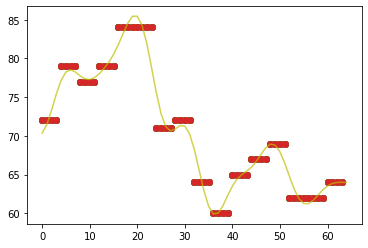

In [56]:
y = mel
y_longer = [x for x in y for a in range(4)]
xs = range(len(y_longer)+1)
ys = y_longer
ys.append(y_longer[-1])
N = len(y_longer)
cs = dct(ys, norm='ortho')

z = np.zeros(0+1)
z[0] = cs[0]
mn = idct(z, n=N, norm='ortho')[0] # centre value
mn2 = idct(cs[:1], n=N, norm='ortho') # centre line
mn3 = ((ys-mn2)**2).mean() # mse from centre line
# print(mn,mn2,mn3)
r=4
N2 = (N//r)+1

# print(N,r,N2)
z2l = np.zeros(N)

for a in range(N-1):
    z = np.zeros(a+1)
    z[0] = cs[0]
    av = idct(z, n=N, norm='ortho')[0]
    zs = idct(cs[:a], n=N, norm='ortho')
    q = 1-(((ys-zs)**2).mean()/mn3) # amount of variance explained by the ath first terms
    plt.scatter(xs[:-1],ys[:-1])

n_dim = 16

za = idct(cs[:n_dim], n=N, norm='ortho')
plt.plot(xs, za, alpha=.7, lw=1.5, c='y')
print(f'{n_dim} dim: {(1-(((ys-za)**2).mean()/mn3))*100}%')
plt.show()   

In [52]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(2,1,sharex=True, sharey=True)

y = mel
y_longer = [x for x in y for a in range(4)]
xs = range(len(y_longer))
ys = y_longer
N = len(y_longer)
cs = dct(ys, norm='ortho')



def init(): 
    ax[0].scatter(xs,ys)
    return line,

z = np.zeros(1)
z[0] = cs[0]
avr = idct(z, n=64, norm='ortho')[0]

line, = ax[0].plot(xs, idct(cs[:0+1], n=N, norm='ortho'))
line2, = ax[1].plot(np.linspace(0,64,256),(cosine(np.linspace(0,64,256), 0, 64))+avr)
text = ax[1].text(0.1,0.8,f'{1}/{N}', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)


def animate(i):
    line.set_ydata(idct(cs[:i+1], n=N, norm='ortho'))  # update the data.
    line2.set_ydata(cs[i]*(cosine(np.linspace(0,64,256), i, 64))+avr)
    text.set_text(f'{i+1}/{N}')
    return line, line2


ani = FuncAnimation(fig, animate, init_func=init, frames=N, blit=True, save_count=50)

vid = HTML(ani.to_html5_video())
plt.close()
vid

In [70]:
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillStyle = "blue";
ctx.fillRect(0, 0, canvas.width, canvas.height);
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
var mousex = []
var mousey = []
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
  mousex.push(mouse.x)
  mousey.push(mouse.y)
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})

</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  liney = eval_js("mousey")
  linex = eval_js("mousex")
  # binary = b64decode(data.split(',')[1])
  # with open(filename, 'wb') as f:
  #   f.write(binary)
  # return linex, [(24-y*24/200)+60 for y in liney] # using notes
  return linex, [(14-y*14/200) for y in liney] # using scale


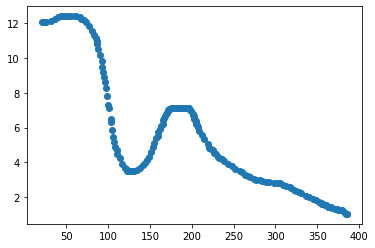

In [223]:
linex, liney = draw(filename = "line_sketch.png", w=400, h=200, line_width=15)
plt.scatter(linex,liney)
plt.show()

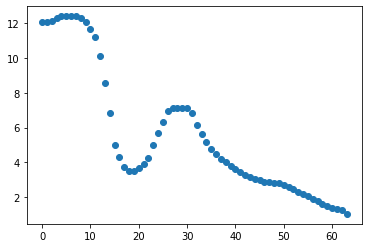

In [224]:
new_y = np.interp(np.linspace(linex[0],linex[-1],64),linex,liney)
plt.scatter(range(64),new_y)

[24.78323887  5.7242903   8.60084929]


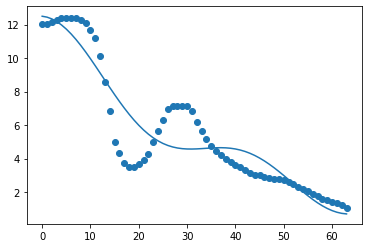

In [240]:
y = new_y
y_longer = [x for x in y for a in range(1)]
xs = range(len(y_longer))
ys = y_longer
N = len(y_longer)
cs = dct(ys, norm='ortho')
print(cs[1:4])
za = idct(cs[:4], n=N, norm='ortho')
plt.scatter(xs,ys)
plt.plot(xs,za)
plt.show()

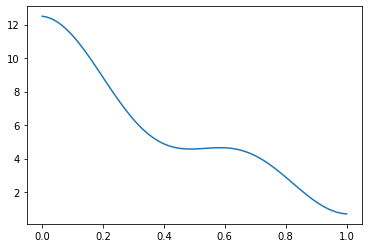

In [226]:
rescaled = np.linspace(0,1,len(xs))
plt.plot(rescaled,za)
plt.show()

### VAE

In [7]:
input_height = 88
cond_height = 3
seq_len = 16
odd = False
# input_height = 88+125
# cond_height = 0
# seq_len = 100
# odd = True
# h=[1,4,5,5]
# n=[1,1,4,20]
h=[1,4,4]
n=[1,1,4]
latent_dim = 256  
enc_hidden_dim = 256
hidden_dim= 256
cond_len = 1
input_len = seq_len + cond_len
teacher_forcing_ratio = 0

In [78]:
class VAE(pl.LightningModule):

    ###############################    
    ############ setup ############
    ###############################

    def __init__(self, input_dim=input_height, hidden_dim=hidden_dim, latent_dim=latent_dim):
        super().__init__()
        
        ### encoder & decoder networks
        self.encoder = lstm_encoder(input_size=input_dim, hidden_size=enc_hidden_dim, output_size=enc_hidden_dim, batch_size=batch_size)
        self.vq = VectorQuantizerEMA(num_embeddings=2048, embedding_dim=16, commitment_cost=0.25, decay=0.99)
        # self.vq = VectorQuantizer(num_embeddings=1024, embedding_dim=4, commitment_cost=0.25)
        self.conductor = lstm_conductor(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)
        self.conductor_2 = lstm_conductor(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)
        self.conductor_3 = lstm_conductor(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)
        self.decoder = lstm_decoder(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)

        ### fully connected layers for latent distribution parameters
        self.fc_mu = nn.Linear((self.encoder.bidirectional+1)*enc_hidden_dim, latent_dim)
        self.fc_var = nn.Linear((self.encoder.bidirectional+1)*enc_hidden_dim, latent_dim)

        ### fully connected layer for output 
        self.fc_out = nn.Linear(latent_dim, input_dim)

        ### fully connected layer for condition 
        self.fc_cond_in = nn.Linear(cond_height, input_height)
        self.fc_cond_lat = nn.Linear(cond_height, latent_dim)

        ### variance for the Gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([-2.6]))

        ### kl-divergence weighting
        self.beta=1e-4

        ### save hyperparameters for lightning checkpoints
        self.save_hyperparameters()

    ### configure pytorch optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    ### reconstruction loss calculated as gaussian likelihood of drawing input vector from predicted vector 
    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        # return log_pxz.sum()
        return log_pxz.mean()

    ### reparameterization trick to add noise to variance for backpropagation
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return (eps * std) + mu

    ### kl-divergence calculated by monte-carlo estimation
    def kl_divergence(self, z, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std)) 
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        kl = (log_qzx - log_pz)
        kl = kl.mean(-1)
        return kl

    def conduct(self, condition, inputs, model, height, num):
        outputs = torch.zeros((batch_size, height*num, latent_dim), device=self.device) 

        for c in range(num): 
            hidden = model.init_hidden(device=self.device)
            if condition != None:
              for d in range(cond_len): 
                _, hidden = model(condition, hidden) 
            for s in range(height): 
                if s==0: 
                    input = inputs[:,c].unsqueeze(1)
                output, hidden = model(input, hidden)
                outputs[:,(c*height)+s] = output.squeeze(1)
            if s<seq_len-1: 
                input = output
        return outputs

    ############################################    
    ############ training procedure ############
    ############################################

    def training_step(self, batch, batch_idx):
        
        ### separate input data and condition
        x = batch
        x, cond = batch 
        cond = cond.unsqueeze(1).float()
        if odd:
          x = x[:,:-1,:]

        ###### ENCODER ######

        ### reset encoder hidden and cell state each batch
        encoder_hidden = self.encoder.init_hidden(device=self.device)

        ### concatenate input and condition
        # input_cond = torch.zeros((batch_size, 1, input_height), device=self.device)
        # # print(input_cond.shape, cond.shape)
        # input_cond[:,:,:cond_height] = cond
        # print(cond)
        input_cond = self.fc_cond_in(cond)
        # print(input_cond.shape, x.shape)
        x_input = torch.cat((input_cond,x),1) # concat along sequence dimension (1)
        # x_input = x

        ### encode x to get the mu and variance parameters as a tensor 
        _, encoder_hidden = self.encoder(x_input, encoder_hidden)

        # get hidden state [0] but not cell state [1], swap batch to first index and get last layer only
        if self.encoder.bidirectional:
          x_encoded = encoder_hidden[0].transpose(0,1)[:,-2:,:].reshape(batch_size,1,self.encoder.hidden_size*2) # concat both directions of last hidden layer
        else:
          x_encoded = encoder_hidden[0].transpose(0,1)[:,-1,:].unsqueeze(1)
          
        

        ###### LATENT SPACE ######

        ### get latent space vector
        if vq:
          mu = self.fc_mu(x_encoded)
          vq_loss, z, perplexity, _ = self.vq(mu)
        else: 
          mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
          z = self.reparameterize(mu, log_var)

        # latent_cond = torch.zeros((batch_size, 1, hidden_dim), device=self.device)
        # latent_cond[:,:,:cond_height] = cond
        latent_cond = self.fc_cond_lat(cond)
      


        ###### CONDUCTOR ######

        #### code here for conductor model from musicvae paper

        # ### initialize output tensor
        # conductor_hidden = self.conductor.init_hidden(device=self.device)
        # conductor_outputs = torch.zeros((batch_size, conductor_height*num_conductors, latent_dim), device=self.device)

        # ### get hidden and cell state (but not output) for conditions
        # # for c in range(cond_len): 
        # # _, conductor_hidden = self.decoder(latent_cond, conductor_hidden) 

        # ### get outputs and hidden and cell state for rest of sequence
        # for s in range(conductor_height): 
        #   if s==0: # first input is always the latent vector
        #     conductor_input = z
          
        #   conductor_output, conductor_hidden = self.conductor(conductor_input, conductor_hidden)
        #   conductor_outputs[:,s] = conductor_output.squeeze(1)

        #   if s<seq_len-1: # subsequent inputs. Don't need to get another input after last decoding
        #     # conductor_input = F.one_hot(torch.argmax(conductor_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)
        #     conductor_input = conductor_output



        conductor_outputs = self.conduct(condition=latent_cond, inputs=z, model=self.conductor, height=h[1], num=n[1])     
        # conductor_2_outputs = self.conduct(condition=latent_cond, inputs=conductor_outputs, model=self.conductor_2, height=h[2], num=n[2])
        # conductor_3_outputs = self.conduct(condition=None, inputs=conductor_2_outputs, model=self.conductor_2, height=h[2], num=n[2])
        decoder_outputs = self.conduct(condition=None, inputs=conductor_outputs, model=self.decoder, height=h[2], num=n[2])
      
        x_hat = self.fc_out(decoder_outputs)



        ###### LOSS ######  

        ### calculate reconstruction loss  
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        
        ### calculate kl-divergence 
        if not vq:
          kl = self.kl_divergence(z, mu, log_var)
        # kl = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        ### calculate proportion of incorrect predictions
        arg_loss = ((torch.argmax(x,-1)-torch.argmax(x_hat,-1))**2).type(torch.FloatTensor)
        arg_loss_mean = arg_loss.mean()
        arg_loss_count = arg_loss.count_nonzero()/torch.numel(torch.argmax(x,-1))    

        # ### increment beta
        # if self.current_epoch >= 50 and self.beta <= 1: 
        #   self.beta+=10e-6 
        
        ### calculate elbo
        if vq: 
          elbo = (vq_loss - recon_loss).mean()
        else:
          elbo = (self.beta*kl.mean() - (recon_loss)).mean()

        ### gradient clipping 
        torch.nn.utils.clip_grad_norm_(self.parameters(), 0.25)


        ###### LOGGING ###### 

        if not batch_idx%(20):
          
          # ### lightning logging
          # self.log_dict({
          #     'elbo': elbo,
          #     'kl': kl.mean(),
          #     'recon_loss': recon_loss.mean()
          # })

          ### print statements
          print()
          print(f'epoch: {self.current_epoch}, step: {self.global_step}')
          if vq: 
            print(f'elbo: {elbo}, vq: {vq_loss.mean()}, recon: {recon_loss.mean()}')
          else:
            print(f'elbo: {elbo}, kl: {kl.mean()}, recon: {recon_loss.mean()}')
          print(f'mean: {arg_loss_mean}, count: {arg_loss_count}, log scale: {self.log_scale.data}')
          # print(f'teacher forcing: {teacher_forcing}')
          print(100+torch.argmax(x,-1)[:3])
          # if odd:
          print('\033[1m'+str(torch.tensor([[100 + x for x in range(n[-1]) for y in range(h[-1])]]))+'\033[0m')
          # else:
          #   print(torch.tensor([[10 + x for x in range(n[3]) for y in range(h[3])]]))
          print(100+torch.argmax(x_hat,-1)[:3])
          
          
          timenow = time.time()-time0
          ### weights and biases logging
          if vq:
            wandb.log({
                'mean': arg_loss_mean, 
                'count': arg_loss_count, 
                'elbo': elbo,
                'time': timenow,
                'vq': vq_loss.mean(),
                'recon_loss': recon_loss.mean(),
                'log_scale': self.log_scale.data,
                'beta': self.beta,
                'epoch': self.current_epoch,
                'step': self.global_step
            })
          else:
              wandb.log({
                'mean': arg_loss_mean, 
                'count': arg_loss_count, 
                'elbo': elbo,
                'time': timenow,
                'kl': kl.mean(),
                'recon_loss': recon_loss.mean(),
                'log_scale': self.log_scale.data,
                'beta': self.beta,
                'epoch': self.current_epoch,
                'step': self.global_step
            })
        
        
        return elbo

    def generate(self, condition=0):
      with torch.inference_mode():

        ### create condition       
        cond = torch.zeros(1,1,latent_dim)
        cond[:,:,condition]=1 # choose condition here
        cond = cond.repeat(batch_size,1,1)

        ### create random vector with zero mean and unit variance in shape of latent space
        ex = torch.zeros(1,latent_dim)
        p = torch.distributions.Normal(torch.zeros_like(ex), torch.ones_like(ex))
        z = p.rsample((batch_size,))
        decoder_input = z

        ### initialize decoder
        decoder_outputs = torch.zeros((batch_size, seq_len, latent_dim), device=self.device)
        decoder_hidden = self.decoder.init_hidden()

        ### NO TEACHER FORCING
        _, decoder_hidden = self.decoder(cond, decoder_hidden)
        for s in range(seq_len):
          decoder_output, decoder_hidden = vae.decoder(decoder_input, decoder_hidden)
          decoder_outputs[:,s] = decoder_output.squeeze(1)
          decoder_input = F.one_hot(torch.argmax(decoder_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)

        ### get most likely notes greedily
        pred = decoder_outputs.argmax(axis=-1)

        return pred

### Training

In [80]:
torch.set_printoptions(linewidth=1000)
teacher_forcing_ratio=0
batch_size = 128
vq=False
vae = VAE().load_from_checkpoint('/content/drive/MyDrive/Colab Notebooks/piano_generation/models/lightning_logs/version_54/checkpoints/epoch=99-step=3899.ckpt') 

In [244]:
input_height = 128
drawn_condition = cs[1:4]
print(drawn_condition)

[24.78323887  5.7242903   8.60084929]


### Generate

In [245]:
def demo():
  with torch.inference_mode():
    ### create condition       
    cond = torch.zeros((1,1,3),device=vae.device)
    cond[:,:,:3]=torch.tensor(drawn_condition)
    cond = cond.repeat(batch_size,1,1)

    ### create random vector with zero mean and unit variance in shape of latent space
    ex = torch.zeros((1,latent_dim), device=vae.device)
    p = torch.distributions.Normal(torch.zeros_like(ex), torch.ones_like(ex))
    z = p.rsample((batch_size,))
    decoder_input = z

    latent_cond = vae.fc_cond_lat(cond)

    conductor_outputs = vae.conduct(condition=latent_cond, inputs=z, model=vae.conductor, height=h[1], num=n[1])        
    decoder_outputs = vae.conduct(condition=latent_cond, inputs=conductor_outputs, model=vae.decoder, height=h[2], num=n[2])

    x_hat = vae.fc_out(decoder_outputs)

    ### get most likely notes greedily
    pred = x_hat.argmax(axis=-1)

  # pred

  cs_all = torch.zeros((128,3), device=vae.device)
  for i in range(128):
    y = pred[i]
    y_longer = [x for x in y for a in range(4)]
    xs = range(len(y_longer)+1)
    ys = y_longer
    ys.append(y_longer[-1])
    N = len(y_longer)
    cs = dct(ys, norm='ortho')
    cs_all[i,:]=torch.tensor(cs[1:4])
  # print(cs_all)  
  # print(cs_all.mean(0))
  # print(cs_all.std(0))

  close = torch.zeros((128), device=vae.device)
  for i in range(128): 
    close[i]=((cs_all[i]-cond[i])**2).sum()
  closest = cs_all[close.argmin()]
  print(close.argmin(), close.min(), closest)

  mel = [note2scale(i) for i in pred[close.argmin()]]

  print(mel)

  display_midi(mel)
  

  y = mel
  y_longer = [x for x in y for a in range(4)]
  xs = range(len(y_longer)+1)
  ys = y_longer
  ys.append(y_longer[-1])
  N = len(y_longer)
  cs = dct(ys, norm='ortho')
  cs_all[i,:]=torch.tensor(cs[1:4])
  plt.scatter(xs, ys)
  za = idct(cs[:4], n=N, norm='ortho')
  plt.plot(xs, za, alpha=.7, lw=1.5, c='y')
  plt.show()

  # tot_var=cs[1:]**2
  # cum_tot_var=[]
  # summ=0
  # for i in range(len(tot_var)):
  #   summ+=tot_var[i]
  #   cum_tot_var.append(summ)
  # plt.bar(list(range(len(tot_var))),cum_tot_var/np.sum(tot_var),alpha=0.5)
  # plt.bar(list(range(len(tot_var))),tot_var/np.sum(tot_var),alpha=0.5)
  # plt.show()

  return(play_midi(mel))

### Display

tensor(53) tensor(14.4269) tensor([22.4996,  8.7098,  9.1476])
[79, 84, 83, 76, 84, 72, 71, 60, 69, 71, 76, 67, 76, 69, 71, 60]


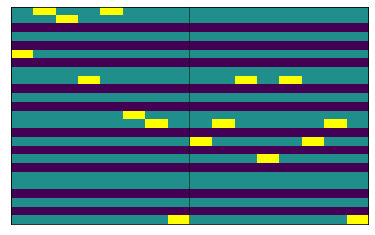

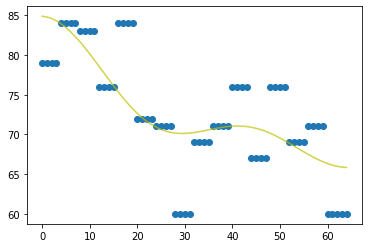

In [246]:
demo()

tensor(52) tensor(17.1181) tensor([20.8827,  4.4273,  8.1299])
[79, 83, 83, 79, 77, 72, 67, 69, 79, 72, 67, 74, 69, 71, 69, 64]


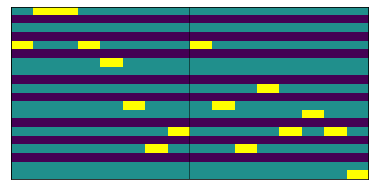

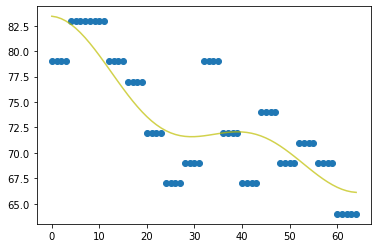

In [249]:
demo()